## Exponential Smoothing Real Data

In [1]:
# install and load necessary packages
!pip install seaborn
!pip install --upgrade --no-deps statsmodels

import pyspark
from datetime import datetime
import seaborn as sns
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os

print('Python version ' + sys.version)
print('Spark version: ' + pyspark.__version__)

Requirement already up-to-date: statsmodels in /opt/app-root/lib/python3.6/site-packages (0.9.0)
Python version 3.6.3 (default, Mar 20 2018, 13:50:41) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-16)]
Spark version: 2.2.1


In [2]:
%env DH_CEPH_KEY = DTG5R3EEWN9JBYJZH0DF
%env DH_CEPH_SECRET = pdcEGFERILlkRDGrCSxdIMaZVtNCOKvYP4Gf2b2x
%env DH_CEPH_HOST = http://storage-016.infra.prod.upshift.eng.rdu2.redhat.com:8080
%env METRIC_NAME = kubelet_docker_operations_latency_microseconds
%env LABEL =

label = os.getenv("LABEL")
where_labels = {}#"metric.group=route.openshift.io"}
metric_name = str(os.getenv("METRIC_NAME"))
print(metric_name)

env: DH_CEPH_KEY=DTG5R3EEWN9JBYJZH0DF
env: DH_CEPH_SECRET=pdcEGFERILlkRDGrCSxdIMaZVtNCOKvYP4Gf2b2x
env: DH_CEPH_HOST=http://storage-016.infra.prod.upshift.eng.rdu2.redhat.com:8080
env: METRIC_NAME=kubelet_docker_operations_latency_microseconds
env: LABEL=
kubelet_docker_operations_latency_microseconds


### Establish Connection to Spark Cluster

set configuration so that the Spark Cluster communicates with Ceph and reads a chunk of data.

In [3]:
import string 
import random

# Set the configuration
# random string for instance name
inst = ''.join(random.choices(string.ascii_uppercase + string.digits, k=4))
AppName = inst + ' - Ceph S3 Prometheus JSON Reader'
conf = pyspark.SparkConf().setAppName(AppName).setMaster('spark://spark-cluster.dh-prod-analytics-factory.svc:7077')
print("Application Name: ", AppName)

# specify number of nodes need (1-5)
conf.set("spark.cores.max", "88")

# specify Spark executor memory (default is 1gB)
conf.set("spark.executor.memory", "400g")

# Set the Spark cluster connection
sc = pyspark.SparkContext.getOrCreate(conf) 

# Set the Hadoop configurations to access Ceph S3
import os
(ceph_key, ceph_secret, ceph_host) = (os.getenv('DH_CEPH_KEY'), os.getenv('DH_CEPH_SECRET'), os.getenv('DH_CEPH_HOST'))
ceph_key = 'DTG5R3EEWN9JBYJZH0DF'
ceph_secret = 'pdcEGFERILlkRDGrCSxdIMaZVtNCOKvYP4Gf2b2x'
ceph_host = 'http://storage-016.infra.prod.upshift.eng.rdu2.redhat.com:8080'
sc._jsc.hadoopConfiguration().set("fs.s3a.access.key", ceph_key) 
sc._jsc.hadoopConfiguration().set("fs.s3a.secret.key", ceph_secret) 
sc._jsc.hadoopConfiguration().set("fs.s3a.endpoint", ceph_host) 

#Get the SQL context
sqlContext = pyspark.SQLContext(sc)

Application Name:  G2T0 - Ceph S3 Prometheus JSON Reader


In [4]:
#Read the Prometheus JSON BZip data
jsonUrl = "s3a://DH-DEV-PROMETHEUS-BACKUP/prometheus-openshift-devops-monitor.1b7d.free-stg.openshiftapps.com/"+metric_name+"/"

jsonFile = sqlContext.read.option("multiline", True).option("mode", "PERMISSIVE").json(jsonUrl)

In [5]:
import pyspark.sql.functions as F
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.types import TimestampType

# create function to convert POSIX timestamp to local date
def convert_timestamp(t):
    return datetime.fromtimestamp(float(t))

def format_df(df):
    #reformat data by timestamp and values
    df = df.withColumn("values", F.explode(df.values))
    
    df = df.withColumn("timestamp", F.col("values").getItem(0))
    
    df = df.withColumn("values", F.col("values").getItem(1))

    # drop null values
    df = df.na.drop(subset=["values"])
    
    # cast values to int
    df = df.withColumn("values", df.values.cast("int"))
    #df = df.withColumn("timestamp", df.values.cast("int"))

    # define function to be applied to DF column
    udf_convert_timestamp = F.udf(lambda z: convert_timestamp(z), TimestampType())

    df = df.na.drop(subset=["timestamp"])
    # convert timestamp values to datetime timestamp
    df = df.withColumn("timestamp", udf_convert_timestamp("timestamp"))

    # drop null values
    df = df.na.drop(subset=["values"])
    
    # calculate log(values) for each row
    #df = df.withColumn("log_values", F.log(df.values))
    
    return df

In [6]:
def extract_from_json(json, name, select_labels, where_labels):
    #Register the created SchemaRDD as a temporary variable
    json.registerTempTable(name)
    
    #Filter the results into a data frame

    query = "SELECT values"
    
    # check if select labels are specified and add query condition if appropriate
    if len(select_labels) > 0:
        query = query + ", " + ", ".join(select_labels)
        
    query = query + " FROM " + name
    
    # check if where labels are specified and add query condition if appropriate
    if len(where_labels) > 0:
        query = query + " WHERE " + " AND ".join(where_labels)

    print("SQL QUERRY: ", query)
    df = sqlContext.sql(query)

    #sample data to make it more manageable
    #data = data.sample(False, fraction = 0.05, seed = 0)
    # TODO: get rid of this hack
    #df = sqlContext.createDataFrame(df.head(1000), df.schema)
    
    return format_df(df)

In [7]:
if label != "":
    select_labels = ['metric.' + label]
else:
    select_labels = []
    
where_labels = {"metric.quantile='0.9'","metric.hostname='free-stg-master-03fb6'"}
# get data and format
df = extract_from_json(jsonFile, metric_name, select_labels, where_labels)
select_labels = []


SQL QUERRY:  SELECT values FROM kubelet_docker_operations_latency_microseconds WHERE metric.quantile='0.9' AND metric.hostname='free-stg-master-03fb6'


In [8]:
df_pd = df.toPandas()


In [9]:
df_pd = df_pd[["values","timestamp"]]
df_pd

,values,timestamp
0,36762,2018-05-30 15:00:59
1,36762,2018-05-30 15:01:59
2,36762,2018-05-30 15:02:59
3,36762,2018-05-30 15:03:59
4,36762,2018-05-30 15:04:59
5,36762,2018-05-30 15:05:59
6,36762,2018-05-30 15:06:59
7,36762,2018-05-30 15:07:59
8,36762,2018-05-30 15:08:59
9,36762,2018-05-30 15:09:59


In [10]:
df_pd.dtypes

values                int64
timestamp    datetime64[ns]
dtype: object

In [11]:
df_pd.sort_values(by='timestamp')
#df_pd = df_pd.set_index("timestamp")
#df_pd.set_index("timestamp")
train_frame = df_pd[0 : int(0.7*len(df_pd))]
test_frame = df_pd[int(0.7*len(df_pd)) : ]


In [12]:
df_pd

,values,timestamp
0,36762,2018-05-30 15:00:59
1,36762,2018-05-30 15:01:59
2,36762,2018-05-30 15:02:59
3,36762,2018-05-30 15:03:59
4,36762,2018-05-30 15:04:59
5,36762,2018-05-30 15:05:59
6,36762,2018-05-30 15:06:59
7,36762,2018-05-30 15:07:59
8,36762,2018-05-30 15:08:59
9,36762,2018-05-30 15:09:59


In [13]:
sc.stop()

In [14]:
df_pd.dtypes

values                int64
timestamp    datetime64[ns]
dtype: object

In [81]:
df_pd_trimmed = df_pd[df_pd.timestamp > datetime(2018,6,17,3,14)]
df_pd_trimmed = df_pd_trimmed[df_pd_trimmed.timestamp < datetime(2018,6,21,3,14)]
#df_pd_trimmed = df_pd_trimmed[["values"]]
train_frame = df_pd_trimmed[0 : int(0.7*len(df_pd_trimmed))]
test_frame = df_pd_trimmed[int(0.7*len(df_pd_trimmed)) : ]

In [16]:
train_frame

,values
82766,34347
82767,34347
82768,34347
82769,34347
82770,34347
82771,34347
82772,34347
82773,34347
82774,34347
82775,5856


### Exponential Smoothing

inspiration: https://github.com/statsmodels/statsmodels/blob/master/examples/notebooks/exponential_smoothing.ipynb

In [17]:
!pip install patsy
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import matplotlib.pyplot as plt
import pandas as pd

In [18]:
train_frame = train_frame.reset_index()
df_series = pd.Series(train_frame["values"])
#df_series.index = pd.DatetimeIndex(train_frame.index, freq="N")

In [19]:
df_series

0        34347
1        34347
2        34347
3        34347
4        34347
5        34347
6        34347
7        34347
8        34347
9         5856
10        5856
11        5856
12        5856
13        5856
14        5856
15        5856
16        5856
17        5856
18        2024
19        2024
20        2024
21        1903
22        1903
23        1903
24        1903
25        1903
26        1903
27        1903
28        1903
29        1903
         ...  
15671    53722
15672    53722
15673    53722
15674    57187
15675    53289
15676    57187
15677    65487
15678    63789
15679    59313
15680    58443
15681    58443
15682    58443
15683    55172
15684    55120
15685    50567
15686    50775
15687    47531
15688    48099
15689    50046
15690    50046
15691    51074
15692    51483
15693    64351
15694    64351
15695    65219
15696    65219
15697    67439
15698    65278
15699    64181
15700    64181
Name: values, Length: 15701, dtype: int64

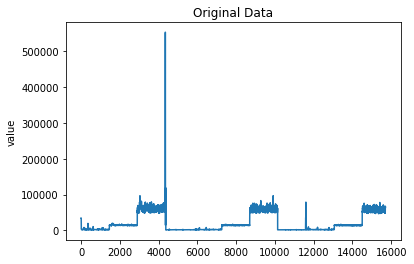

In [20]:
ax=df_series.plot(title="Original Data")
ax.set_ylabel("value")
plt.show()

### Simple Exponential Smoothing

Text(0.5,0,'timestamp')

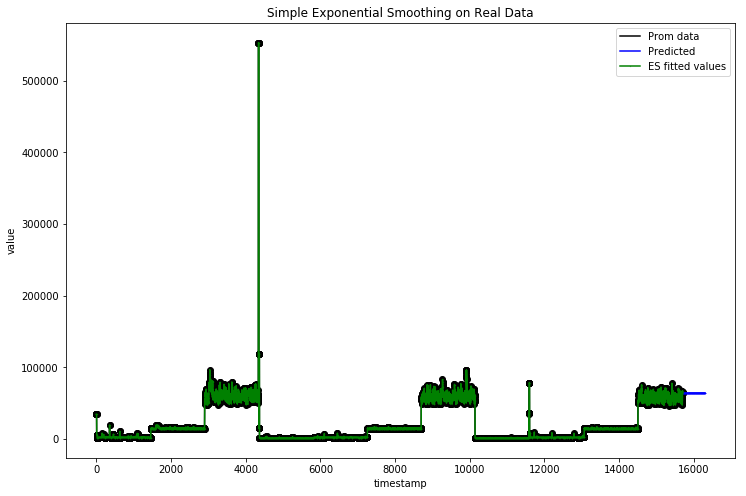

In [58]:
fit1  =  SimpleExpSmoothing(df_series).fit()
fcast1 = fit1.forecast(600)
ax = df_series.plot(marker='o', color='black',legend=True, label="Prom data", figsize=(12,8))
fcast1.plot(marker='o', markersize=0.2, ax=ax, color='blue', legend=True, label="Predicted")
fit1.fittedvalues.plot(marker='o', markersize=0.2, ax=ax, color='green',legend=True, label="ES fitted values")
plt.title("Simple Exponential Smoothing on Real Data")
plt.ylabel("value")
plt.xlabel("timestamp")

### Holt Winters Method (Additive)
The additive method gives a prediction by adding the seasonality, trend, and value components of the model together. This method is ideal for time series when the seasonality is relatively constant.

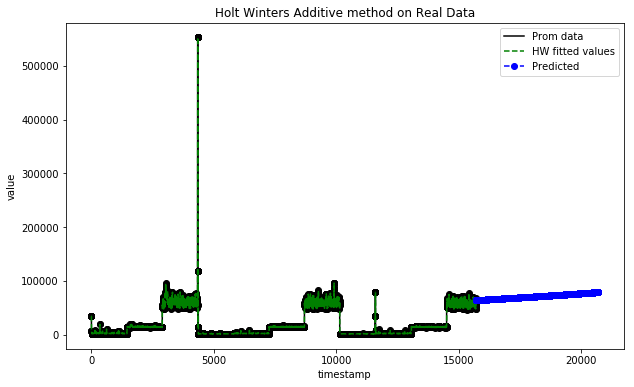

In [64]:
fit2 = ExponentialSmoothing(df_series, seasonal_periods=4, trend='add', seasonal='add').fit(use_boxcox=True)
results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE"])
params = ['smoothing_level', 'smoothing_slope', 'damping_slope', 'smoothing_seasonal', 'initial_level', 'initial_slope']
results["Additive"] = [fit2.params[p] for p in params] + [fit2.sse]
ax = df_series.plot(figsize=(10,6), marker='o', color='black',legend=True, label="Prom data")
fit2.fittedvalues.plot(ax=ax, style='--', color='green', legend=True, label="HW fitted values")
fit2.forecast(5000).plot(ax=ax, style='--', marker='o', color='blue', legend=True, label="Predicted")

plt.title("Holt Winters Additive method on Real Data")
plt.ylabel("value")
plt.xlabel("timestamp")
plt.show()

### Holt Winter's Method (Multiplicative)
This method is used when the trend and seasonality vary with time. This is effective for when the trend is non-stationary (ie. changes with time).

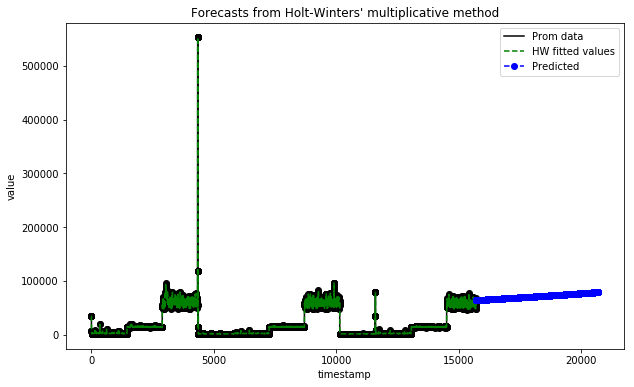

In [63]:
fit2 = ExponentialSmoothing(df_series, seasonal_periods=4, trend='add', seasonal='mult').fit(use_boxcox=True)
results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE"])
params = ['smoothing_level', 'smoothing_slope', 'damping_slope', 'smoothing_seasonal', 'initial_level', 'initial_slope']
results["Additive"] = [fit2.params[p] for p in params] + [fit2.sse]
ax = df_series.plot(figsize=(10,6), marker='o', color='black',legend=True, label="Prom data" )
fit2.fittedvalues.plot(ax=ax, style='--', color='green', legend=True, label="HW fitted values")
fit2.forecast(5000).plot(ax=ax, style='--', marker='o', color='blue', legend=True, label="Predicted")
plt.title(" Holt-Winters' Multiplicative method")
plt.ylabel("value")
plt.xlabel("timestamp")
plt.show()

In [20]:
from __future__ import print_function
import statsmodels.api as sm
from statsmodels.tsa.arima_process import arma_generate_sample
np.random.seed(12345)


In [21]:
arparams = np.array([.75, -.25])
maparams = np.array([.65, .35])

In [22]:
arparams = np.r_[1, -arparams]
maparams = np.r_[1, maparams]
nobs = 250
y = arma_generate_sample(arparams, maparams, nobs)

In [23]:
#dates = sm.tsa.datetools.dates_from_range('1980m1', length=nobs)
y = df_series#pd.Series(y, index=dates)
arma_mod = sm.tsa.ARMA(y, order=(2,2))
arma_res = arma_mod.fit(trend='nc', disp=-1)

In [24]:
print(arma_res.summary())

                              ARMA Model Results                              
Dep. Variable:                 values   No. Observations:                15701
Model:                     ARMA(2, 2)   Log Likelihood             -159650.441
Method:                       css-mle   S.D. of innovations           6305.157
Date:                Fri, 06 Jul 2018   AIC                         319310.881
Time:                        16:39:30   BIC                         319349.189
Sample:                             0   HQIC                        319323.563
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ar.L1.values     1.4139      0.158      8.924      0.000       1.103       1.724
ar.L2.values    -0.4237      0.156     -2.719      0.007      -0.729      -0.118
ma.L1.values    -0.4332      0.159     -2.73

In [25]:
y.tail()

15696    65219
15697    67439
15698    65278
15699    64181
15700    64181
Name: values, dtype: int64

Text(0.5,1,'Time Series Forecasting using the ARIMA model')

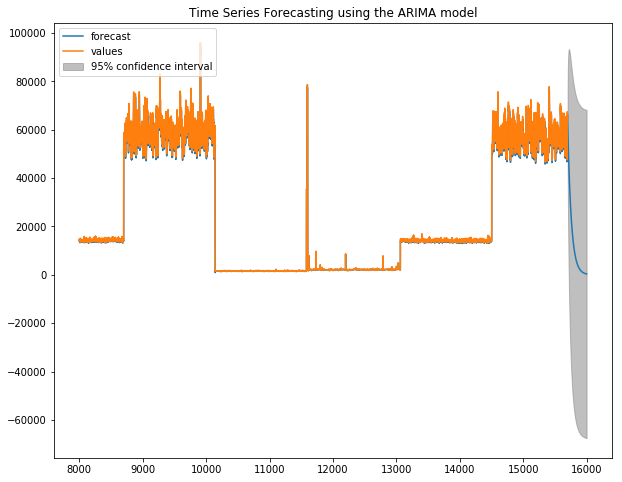

In [49]:
fig, ax = plt.subplots(figsize=(10,8))
fig = arma_res.plot_predict(start=8000, end=16000, ax=ax)
legend = ax.legend(loc='upper left')
plt.title("Time Series Forecasting using the ARIMA model")

Text(0.5,1,'Time Series Forecasting using the ARIMA model')

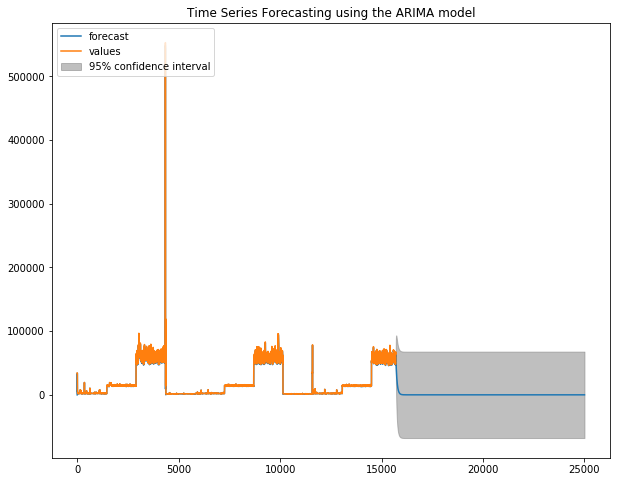

In [50]:
fig, ax = plt.subplots(figsize=(10,8))
fig = arma_res.plot_predict(start=0, end=25000, ax=ax)
legend = ax.legend(loc='upper left')
plt.title("Time Series Forecasting using the ARIMA model")

In [65]:
!pip install fbprophet

    100% |████████████████████████████████| 3.4MB 16.6MB/s ta 0:00:01
    100% |████████████████████████████████| 68.1MB 8.9MB/s ta 0:00:0111                      | 4.5MB 94.9MB/s eta 0:00:01
  Running setup.py install for fbprophet ... done


In [66]:
from fbprophet import Prophet

#### Forecasting __list_images__

In [ ]:
temp_frame = get_filtered_op_frame(OP_TYPE)
temp_frame = temp_frame.set_index(temp_frame.timestamp)
temp_frame = temp_frame[['timestamp','value']]

#### Separating train and test frame
Separation is being done to check the forecast quality and residual plot and its distribution

In [ ]:
train_frame = temp_frame[0 : int(0.7*len(temp_frame))]
test_frame = temp_frame[int(0.7*len(temp_frame)) : ]

In [ ]:
print(len(train_frame), len(test_frame), len(temp_frame))

In [76]:
train_p=train_frame
train_p['y'] = train_frame['values']
train_p['ds'] = train_frame['timestamp']

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [82]:
test_p=test_frame
train_p['y'] = train_frame['values']
train_p['ds'] = train_frame['timestamp']

#### Initialisation of model
We can add seasonality when initialising the model. Its little hard to understand but, inital approach will show some seaonality in forecast plot. Seasonality can be week, daily month or yearly
* We can add additinal features as well for better forecasting

In [78]:
m = Prophet()

#### Model fitting
It is being trained on training data

In [79]:
m.fit(train_p)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
/opt/app-root/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


#### Make future frame wholding the timestamps of future for forecasting. 
For example, if we run the model every 12 hours, we can make the future frame for next 11 hours 59 minutes, taking frequency as 1 minute. As the time capture is being done for every one minute

In [83]:
future = m.make_future_dataframe(periods= int(len(test_p) * 1.1),freq= '1MIN')

In [84]:
forecast = m.predict(future)

In [85]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-06-17 23:59:59,23541.156486,-12123.271112,55904.790931,23541.156486,23541.156486,-1107.503995,-1107.503995,-1107.503995,-1107.503995,-1107.503995,-1107.503995,0.0,0.0,0.0,22433.652491
1,2018-06-17 23:59:59,23541.156486,-13011.160637,59179.004816,23541.156486,23541.156486,-1107.503995,-1107.503995,-1107.503995,-1107.503995,-1107.503995,-1107.503995,0.0,0.0,0.0,22433.652491
2,2018-06-17 23:59:59,23541.156486,-13642.472200,60539.777282,23541.156486,23541.156486,-1107.503995,-1107.503995,-1107.503995,-1107.503995,-1107.503995,-1107.503995,0.0,0.0,0.0,22433.652491
3,2018-06-18 00:00:59,23542.708790,-14833.892816,57834.224556,23542.708790,23542.708790,-1063.008281,-1063.008281,-1063.008281,-1063.008281,-1063.008281,-1063.008281,0.0,0.0,0.0,22479.700509
4,2018-06-18 00:00:59,23542.708790,-10373.433107,57276.211722,23542.708790,23542.708790,-1063.008281,-1063.008281,-1063.008281,-1063.008281,-1063.008281,-1063.008281,0.0,0.0,0.0,22479.700509


#### Useful features in forecasted frame

In [ ]:
forecasted_features = ['ds','yhat','yhat_lower','yhat_upper']

#### Plotting the future with history
Confidence interval will be also printed for expectation. After completion of historical plot, future plot will be in right part of graph

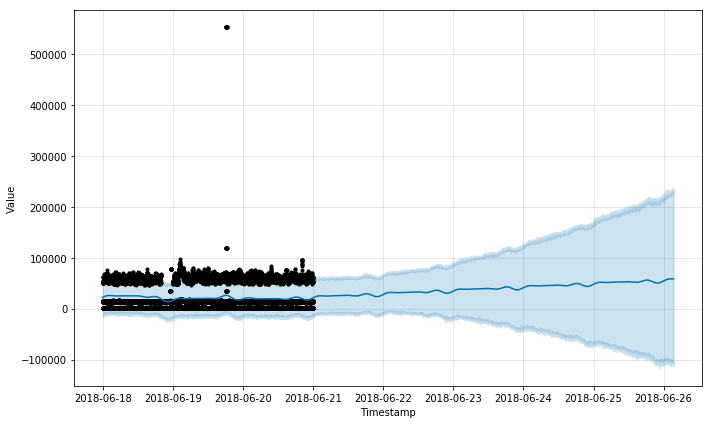

In [86]:
m.plot(forecast,xlabel="Timestamp",ylabel="Value");